# Variable encodings demo notebook
Plan here is to show how to build a simple NN model from a dataset that includes categorical variables. We'll convert the categoricals to indices, then train encodings for each.

## Import libraries

In [136]:
import os
import urllib.request                              # Simple Python library for HTTP
import pandas as pd
import seaborn as sns                        # Statistical visualization library based on Matplotlib

from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding

## Get data
We'll download the Census dataset (if first time)

In [11]:
# Helper function to download datasets
def download_if_needed(url, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    name = os.path.basename(url)
    fname = os.path.join(path, name)
    if not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)
        print('Downloaded {}'.format(fname))
    else:
        print('{} already exists, skipping.'.format(fname))

Do download

In [13]:
DATA_PATH = 'data'
CENSUS_DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

for url in CENSUS_DATASET:
    download_if_needed(url, DATA_PATH)

data/adult.data already exists, skipping.
data/adult.names already exists, skipping.
data/adult.test already exists, skipping.


## Quick exploration
Import

In [51]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
         'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
         'label']
df_train = pd.read_csv(os.path.join(DATA_PATH, 'adult.data'), names=names, comment='|', index_col=False)
df_test = pd.read_csv(os.path.join(DATA_PATH, 'adult.test'), names=names, comment='|', index_col=False)

Show variables, distribution of categoricals

In [52]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [61]:
df_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
label             object
dtype: object

In [75]:
cat_cols = list(df_train.columns[df_train.dtypes == 'O'])
num_cols = list(df_train.columns[df_train.dtypes == 'int64'])

In [77]:
print('cat cols', cat_cols)
print('num cols', num_cols)

cat cols ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'label']
num cols ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [99]:
df_train.describe(include='all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [54]:
df_train['label'].describe()

count      32561
unique         2
top        <=50K
freq       24720
Name: label, dtype: object

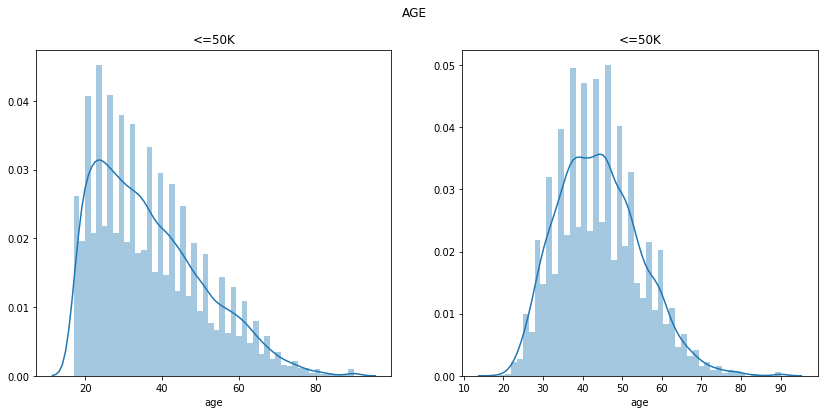

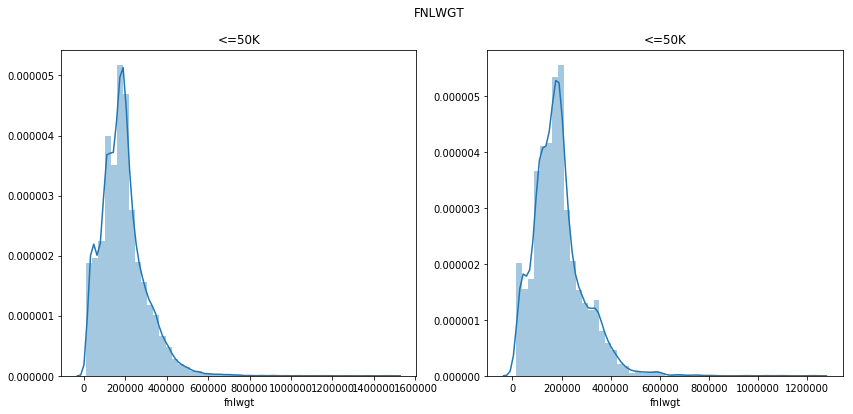

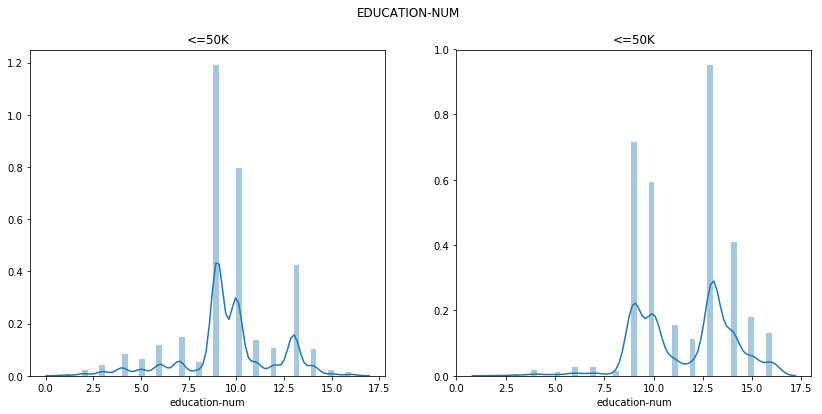

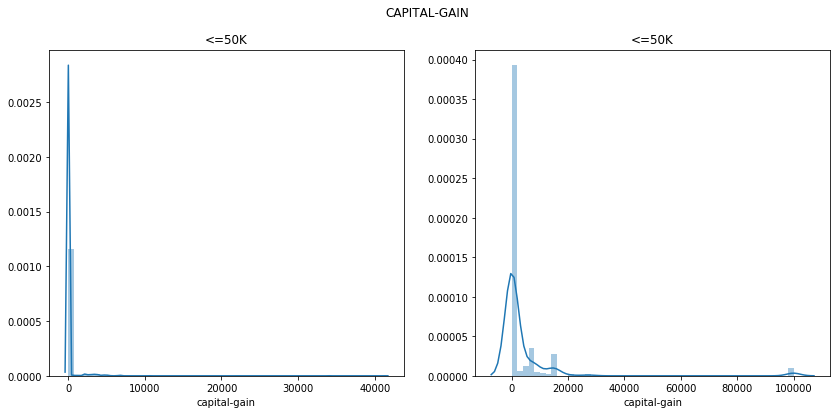

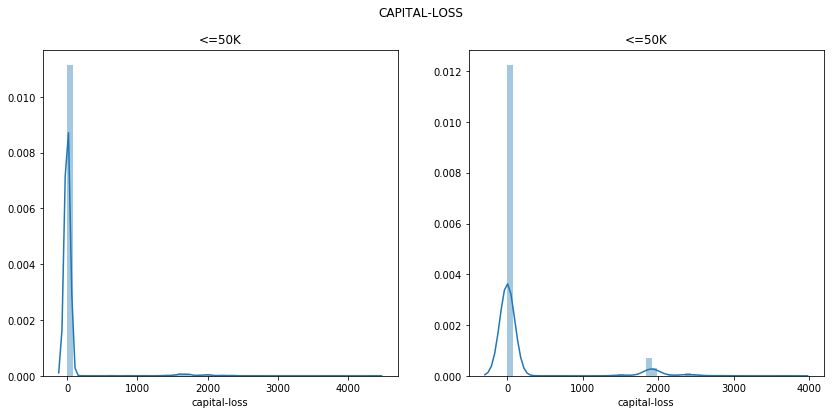

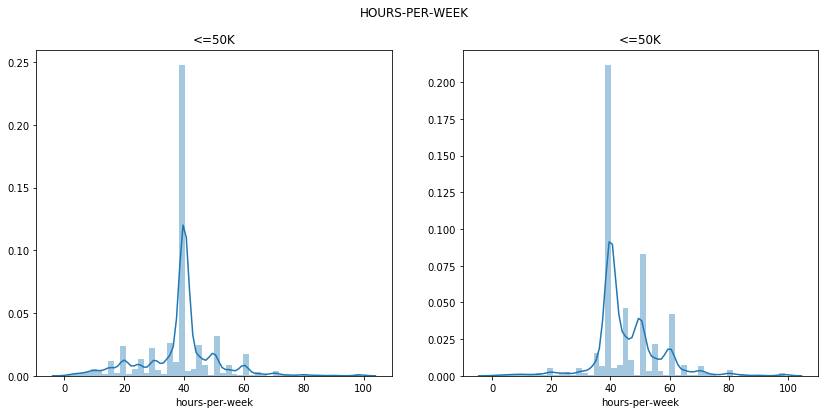

In [98]:
for col in num_cols:
    plt.figure(figsize=(14,6))
    plt.suptitle(str.upper(col))   
    plt.subplot(121)
    plt.gca().set_title('<=50K')
    sns.distplot(df_train[df_train['label']==' <=50K'][col])
    plt.subplot(122)
    plt.gca().set_title('<=50K')
    sns.distplot(df_train[df_train['label']!=' <=50K'][col])
    plt.show()


In [94]:
for col in cat_cols:
    display((df_train.groupby([col, 'label'])['label'].count()/len(df_train)*100).unstack())

label,<=50K,>50K
workclass,,
?,5.052056,0.586591
Federal-gov,1.808913,1.139400
Local-gov,4.533030,1.894905
Never-worked,0.021498,NaN
Private,54.460858,15.242161
Self-emp-inc,1.517152,1.910261
Self-emp-not-inc,5.580295,2.223519
State-gov,2.902245,1.084119
Without-pay,0.042996,NaN


label,<=50K,>50K
education,,
10th,2.674979,0.190412
11th,3.424342,0.184270
12th,1.228463,0.101348
1st-4th,0.497528,0.018427
5th-6th,0.973557,0.049139
7th-8th,1.861122,0.122846
9th,1.495654,0.082921
Assoc-acdm,2.463069,0.813857
Assoc-voc,3.135653,1.108688


label,<=50K,>50K
marital-status,,
Divorced,12.223212,1.421947
Married-AF-spouse,0.039925,0.030712
Married-civ-spouse,25.441479,20.552194
Married-spouse-absent,1.179325,0.104419
Never-married,31.301250,1.507939
Separated,2.945241,0.202696
Widowed,2.788612,0.261048


label,<=50K,>50K
occupation,,
?,5.073554,0.586591
Adm-clerical,10.021191,1.557077
Armed-Forces,0.024569,0.003071
Craft-repair,9.735573,2.853106
Exec-managerial,6.443291,6.044040
Farming-fishing,2.699549,0.353183
Handlers-cleaners,3.943368,0.264120
Machine-op-inspct,5.380670,0.767790
Other-service,9.698719,0.420749


label,<=50K,>50K
relationship,,
Husband,22.342680,18.175117
Not-in-family,22.877062,2.628912
Other-relative,2.899174,0.113633
Own-child,15.358865,0.205768
Unmarried,9.913700,0.669513
Wife,2.527564,2.288013


label,<=50K,>50K
race,,
Amer-Indian-Eskimo,0.844569,0.110562
Asian-Pac-Islander,2.343294,0.847640
Black,8.405761,1.188538
Other,0.755505,0.076779
White,63.569915,21.857437


label,<=50K,>50K
sex,,
Female,29.458555,3.620896
Male,46.460490,20.460060


label,<=50K,>50K
native-country,,
?,1.342096,0.448389
Cambodia,0.036854,0.021498
Canada,0.251835,0.119775
China,0.168914,0.061423
Columbia,0.175056,0.006142
Cuba,0.214981,0.076779
Dominican-Republic,0.208839,0.006142
Ecuador,0.073708,0.012285
El-Salvador,0.297902,0.027640


label,<=50K,>50K
label,,
<=50K,75.919044,NaN
>50K,NaN,24.080956


## Clean up
Deal with missing variables

In [100]:
df_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

## Split test/train, choose variables

In [131]:
X_train, y_train = df_train.iloc[:,:-1], df_train.label
X_test, y_test = df_test.iloc[:,:-1], df_test.label

cols_use = [c for c in X_train.columns if (not c in ['fnlwgt'])]

X_train = X_train[cols_use]
X_test = X_test[cols_use]

## Create indices for categoricals and target
Following https://www.kaggle.com/aquatic/entity-embedding-neural-net

In [132]:
cat_cols = list(X_train.columns[X_train.dtypes == 'O'])

col_vals_dict = {c: list(X_train[c].unique()) for c in X_train.columns if X_train[c].dtype=='O'}

embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions

workclass: 9 values
education: 16 values
marital-status: 7 values
occupation: 15 values
relationship: 6 values
race: 5 values
native-country: 42 values




In [135]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

# Model definition
Custom embedding for each categorical input

In [ ]:
def build_embedding_network():
    
    inputs = []
    embeddings = []
    
    # Cat columns
    
    input_workclass = Input(shape=(1,))
    embedding = Embedding(9, 3, input_length=1)(input_workclass)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_workclass)
    embeddings.append(embedding)
    
    input_education = Input(shape=(1,))
    embedding = Embedding(16, 3, input_length=1)(input_education)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_education)
    embeddings.append(embedding)
    
    input_marital_status = Input(shape=(1,))
    embedding = Embedding(7, 3, input_length=1)(input_marital_status)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_marital_status)
    embeddings.append(embedding)
    
    input_occupation = Input(shape=(1,))
    embedding = Embedding(15, 3, input_length=1)(input_occupation)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_occupation)
    embeddings.append(embedding)
    
    input_relationship = Input(shape=(1,))
    embedding = Embedding(6, 3, input_length=1)(input_relationship)
    embedding = Reshape(target_shape=(3,))(embedding)
    inputs.append(input_relationship)
    embeddings.append(embedding)
    
    input_race = Input(shape=(1,))
    embedding = Embedding(5, 2, input_length=1)(input_race)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_race)
    embeddings.append(embedding)
    
    input_country = Input(shape=(1,))
    embedding = Embedding(42, 5, input_length=1)(input_country)
    embedding = Reshape(target_shape=(5,))(embedding)
    inputs.append(input_country)
    embeddings.append(embedding)
    
    # Num columns
    
    input_numeric = Input(shape=(5,))
    embedding_numeric = Dense(16)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)

    x = Concatenate()(embeddings)
    x = Dense(20, activation='relu')(x)
    x = Dropout(.15)(x)
    x = Dense(10, activation='relu')(x)
    x = Dropout(.15)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, output)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model


In [121]:
from sklearn.preprocessing import LabelEncoder

class multiColumnEncoder():
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, df):
        self.encoders = dict()
        for col in self.columns:
            self.encoders[col] = LabelEncoder()
            self.encoders[col]
            .fit(df[col].values)
    
    def transform(self, df):
        output = df.copy()
        for col in self.columns:
            output[col] = self.encoders[col].transform(df[col])
        return output
    


# Tests

In [125]:
df = pd.DataFrame({
    'a': ['a','b','c'],
    'b':['A','B','C'],
    'c':[1,2,3]
})

df2 = pd.DataFrame({
    'a': ['b','f','a'],
    'b':['C','B','A'],
    'c':[4,5,6]
})

display(df)

mce = multiColumnEncoder(['a','b'])
mce.fit(df)
df = mce.transform(df)
display(df)

display(df2)
df2 = mce.transform(df2)
display(df2)

,a,b,c
0,a,A,1
1,b,B,2
2,c,C,3


,a,b,c
0,0,0,1
1,1,1,2
2,2,2,3


,a,b,c
0,b,C,4
1,f,B,5
2,a,A,6


ValueError: y contains previously unseen labels: 'f'

In [116]:
type(df['a'].values)


numpy.ndarray

In [137]:
?Embedding